In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("final_noduplicates.csv")

In [4]:
df.describe(include='all')

,...1,Animal #,Species,Primary Breed,Gender,Altered,Intake Date,Intake Subtype,Location Found,Jurisdiction In,...,...20,...21,...22,...23,LocationPlus,address_google,pnt,lon,lat,Duplicates
count,6424.000000,6424,6424,6424,6424,6424,6424,6424,6424,6424,...,107.000000,1022,1045,1043.000000,6424,6424,6424,6424.000000,6424.000000,6424.000000
unique,NaN,6322,9,168,3,2,6078,9,4355,48,...,NaN,82,8,NaN,4642,2171,2100,NaN,NaN,NaN
top,NaN,A0045185350,Cat,Domestic Shorthair,M,Yes,9/23/2022 8:10,Stray without ID,Carpenter and Packard,Ypsilanti,...,NaN,Ypsilanti,MI,NaN,"Jackson and Zeeb WC-Scio Twp , Michigan","Washtenaw Ave & Golfside Rd, Pittsfield Charte...","-83.6610765, 42.2501431",NaN,NaN,NaN
freq,NaN,4,4677,3679,3380,5793,5,3415,29,1618,...,NaN,333,1037,NaN,25,54,54,NaN,NaN,NaN
mean,5358.023661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,462.644860,NaN,NaN,48115.190796,NaN,NaN,NaN,-83.676080,42.267862,0.176370
std,3362.452355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1767.878103,NaN,NaN,2268.800266,NaN,NaN,NaN,0.169936,0.104895,0.381164
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,3049.000000,NaN,NaN,NaN,-86.200601,41.724553,0.000000
25%,2243.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.500000,NaN,NaN,48105.000000,NaN,NaN,NaN,-83.746468,42.230668,0.000000
50%,5282.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84.000000,NaN,NaN,48170.000000,NaN,NaN,NaN,-83.656461,42.256277,0.000000
75%,8278.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,242.000000,NaN,NaN,48197.000000,NaN,NaN,NaN,-83.582597,42.309081,0.000000


In [5]:
# create found variable
df['Returned'] = np.where(df['Outcome Type'].str.contains('Stray Reclaim'),1,0)

In [6]:
df.Returned.value_counts()

0    5327
1    1097
Name: Returned, dtype: int64

In [7]:
# set index for ease to get duplicates
df = df.set_index("Animal #")

In [9]:
df.groupby('Returned').Species.value_counts()

Returned  Species
0         Cat        4203
          Dog         963
          Rabbit       62
          Bird         55
          Rodent       32
          Ferret        5
          Reptile       4
          Pig           3
1         Dog         604
          Cat         474
          Bird          9
          Rabbit        4
          Ferret        2
          Rodent        2
          Exotic        1
          Reptile       1
Name: Species, dtype: int64

In [12]:
# convert to datetime
df['Outcome Date'] = pd.to_datetime(df['Outcome Date'])
df['Intake Date'] = pd.to_datetime(df['Intake Date'])
df['intake_month'] = df['Intake Date'].dt.month
df['YearMonth'] = df['Intake Date'].dt.strftime('%Y-%m')

In [13]:
df['Species_cat'] = np.where(df.Species.isin(['Cat','Dog']), df.Species, 'Other')
monthly_counts_species = df.groupby(['Species_cat','YearMonth'])['Species'].count().sort_index().reset_index()
monthly_counts_species.columns = ['Species','YearMonth', 'Count']

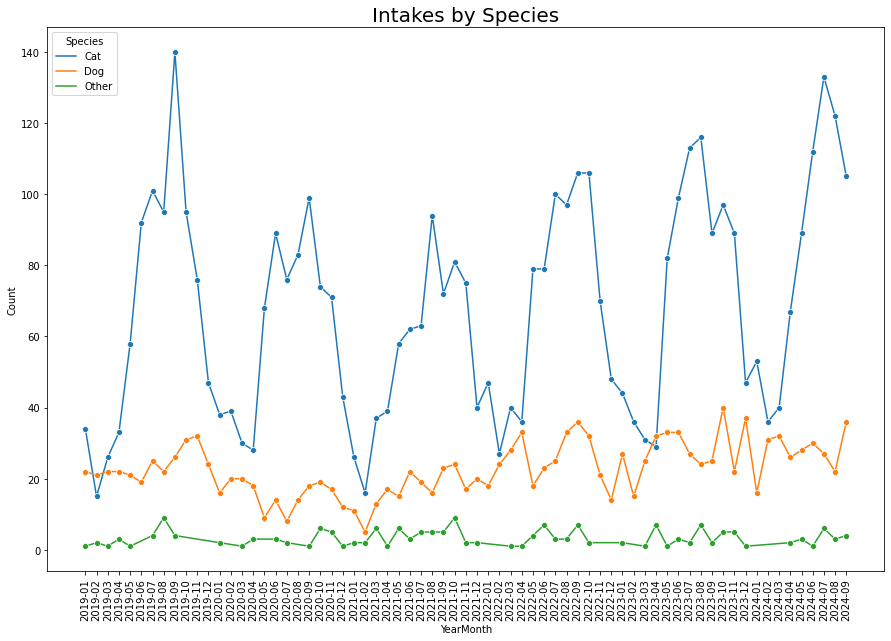

In [14]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=monthly_counts_species, x='YearMonth', y='Count',hue='Species', marker='o')
plt.title("Intakes by Species", fontsize=20)
plt.xticks(rotation=90);

In [15]:
monthly_counts_returned_species = df.groupby(['Species_cat','Returned','YearMonth'])['Species'].count().sort_index().reset_index()
monthly_counts_returned_species.columns = ['Species','Returned','YearMonth', 'Count']
monthly_counts_returned_species['Group'] = monthly_counts_returned_species.Species + '_' + monthly_counts_returned_species.Returned.astype(str)

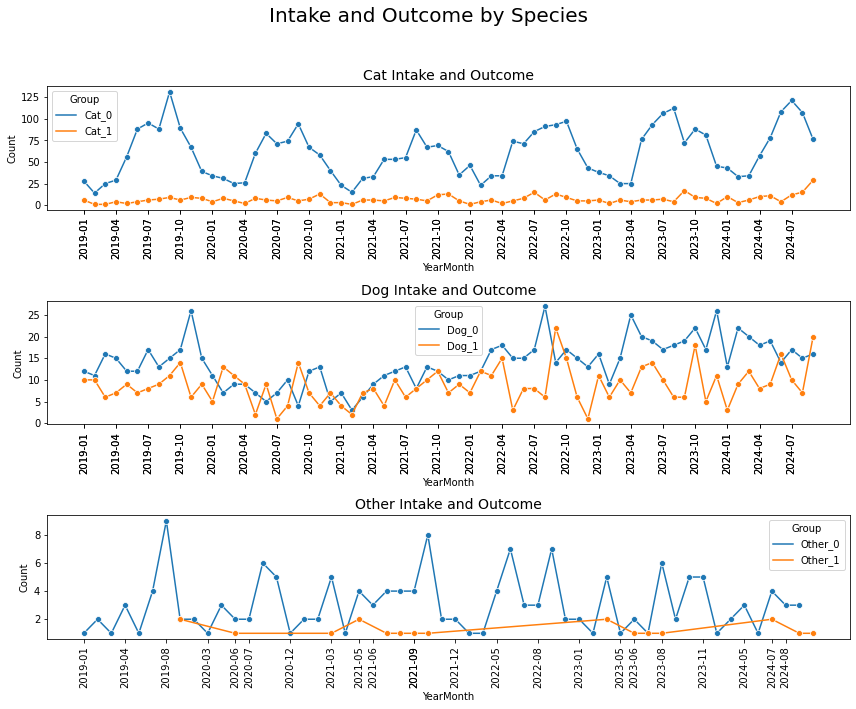

In [16]:
# Unique species
species_list = monthly_counts_returned_species['Species'].unique()

# Create subplots
fig, axes = plt.subplots(3,1, figsize=(12, 10))#, sharex=True)

# Plot each species in its own subplot
for ax, species in zip(axes, species_list):
    species_data = monthly_counts_returned_species[monthly_counts_returned_species['Species'] == species]  # Filter data for the species
    sns.lineplot(
        data=species_data,
        x='YearMonth',
        y='Count',
        hue='Group',
        marker='o',
        ax=ax
    )
    ax.set_title(f"{species} Intake and Outcome", fontsize=14)
    every_3rd = species_data['YearMonth'].iloc[::3]
    ax.set_xticks(every_3rd)
    ax.set_xticklabels(every_3rd, rotation=90)

# Adjust layout and main title
fig.suptitle("Intake and Outcome by Species", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<AxesSubplot:xlabel='Days_to_Outcome', ylabel='Count'>

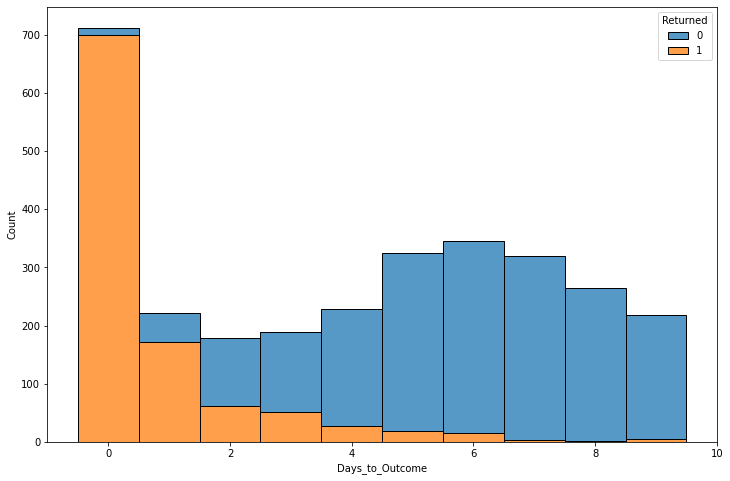

In [18]:
plt.figure(figsize=(12, 8))
# change hue to "Species" and filter on only returned animals to view time to outcome by species
df['Days_to_Outcome'] = (df['Outcome Date'] - df['Intake Date']).dt.days
sns.histplot(x='Days_to_Outcome', hue='Returned', multiple="stack", discrete=True, data=df[df.Days_to_Outcome<10])

In [43]:
return_data = df.groupby(["Returned", "Outcome Type", "Species_cat"])["Days_to_Outcome"].agg(["mean", "count"])
#return_data = return_data.reset_index()#.count
return_data[return_data[('count')]>10]

mean  count
Returned Outcome Type                 Species_cat                  
0        Adoption                     Cat          22.139755   3914
                                      Dog          22.545984    859
                                      Other        19.892086    139
         Transfer Out                 Cat           1.888889     18
1        Stray Reclaim-Lost Report    Cat           1.647059     51
                                      Dog           0.777778     81
         Stray Reclaim-Microchip      Cat           0.545098    255
                                      Dog           0.515789    190
         Stray Reclaim-Other Tag      Dog           0.000000     17
         Stray Reclaim-Owner Visit/Id Cat           2.700000    130
                                      Dog           0.917563    279
         Stray Reclaim-Social Media   Dog           1.294118     17

<AxesSubplot:xlabel='Days_to_Outcome', ylabel='Count'>

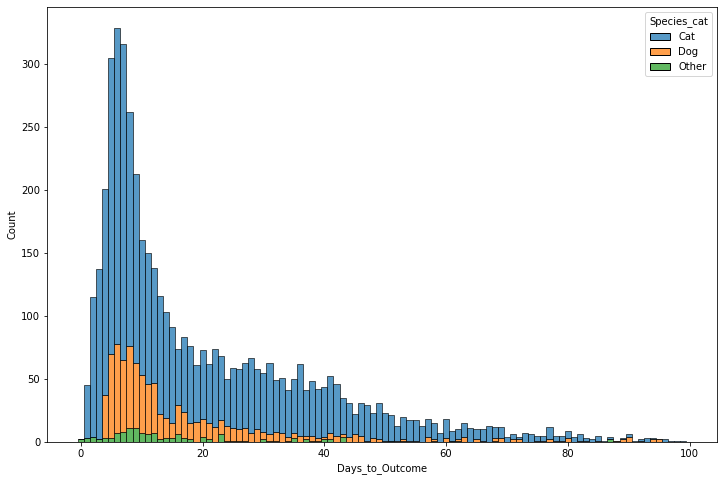

In [59]:
plt.figure(figsize=(12, 8))
#[["Intake Date","Outcome Date", 'Days_to_Outcome']]
sns.histplot(x='Days_to_Outcome', hue='Species_cat',
             multiple='stack',discrete=True, 
             data=df[(df["Outcome Type"] == "Adoption") & (df["Days_to_Outcome"] < 100)])